In [1]:
@file:DependsOn("com.squareup:gifencoder:0.10.1")

In [2]:
val test_input = """..@@.@@@@.
@@@.@.@.@@
@@@@@.@.@@
@.@@@@..@.
@@.@@@@.@@
.@@@@@@@.@
.@.@.@.@@@
@.@@@.@@@@
.@@@@@@@@.
@.@.@@@.@.
"""

In [3]:
import java.nio.file.Files
import java.nio.file.Paths
import java.awt.image.BufferedImage
import java.awt.Color
import java.awt.Graphics2D
import java.awt.Image

var rows = 0
var cols = 0

fun String.prepMap() : Map<Pair<Int, Int>, Boolean> {
    val m = mutableMapOf<Pair<Int,Int>, Boolean>()
    this.split('\n')
        .filter { it.isNotEmpty() }
        .asSequence().forEachIndexed { row, content ->
            if (row > rows) rows = row
            content.forEachIndexed { col, content ->
                if (col > cols) cols = col
                m[Pair(col, row)] = content == '@'
            }
        }
    return m
}

val use_input = true
val debug = true

val m = if (use_input) {
    Files.readString(Paths.get("input.txt"))
} else {
    test_input
}.prepMap()


fun printMap(m: Map<Pair<Int,Int>, Boolean>) {
    for (x in 0..cols) {
        for (y in 0..rows) {
            print(if (m.getOrDefault(Pair(x,y), false)) "@" else "." )
        }
        println()
    }
}

// Configuration
val cellSize = 1 // pixels per cell
val imageWidth = (cols + 1) * cellSize
val imageHeight = (rows + 1) * cellSize

fun createImage(oldMap: Map<Pair<Int,Int>, Boolean>, newMap: Map<Pair<Int,Int>, Boolean>, oldImage: Image?): BufferedImage {
    val image = BufferedImage(imageWidth, imageHeight, BufferedImage.TYPE_INT_RGB)
    val g: Graphics2D = image.createGraphics()

    if (oldImage != null) {
        g.drawImage(oldImage, 0, 0, null)
    }

    // Set background
    g.color = Color(0,0,0,32)
    g.fillRect(0, 0, imageWidth, imageHeight)

    // Draw cells
    for (x in 0..cols) {
        for (y in 0..rows) {
            val inOldMap = oldMap.getOrDefault(Pair(x, y), false)
            val inNewMap = newMap.getOrDefault(Pair(x, y), false)
            if (inOldMap && !inNewMap) {
                g.color = Color.GREEN
                g.fillRect(x * cellSize, y * cellSize, cellSize, cellSize)
            } else if (inNewMap) {
                g.color = Color.WHITE
                g.fillRect(x * cellSize, y * cellSize, cellSize, cellSize)
            }
        }
    }

    g.dispose()
    return image
}

fun checkAdjacent(map: Map<Pair<Int, Int>, Boolean>, x: Int, y: Int) : Int {
    var count = 0
    val default = false
    if (map.getOrDefault(Pair(x-1,y-1), default)) count++
    if (map.getOrDefault(Pair(x  ,y-1), default)) count++
    if (map.getOrDefault(Pair(x+1,y-1), default)) count++
    if (map.getOrDefault(Pair(x-1,y), default)) count++
    if (map.getOrDefault(Pair(x+1,y), default)) count++
    if (map.getOrDefault(Pair(x-1,y+1), default)) count++
    if (map.getOrDefault(Pair(x  ,y+1), default)) count++
    if (map.getOrDefault(Pair(x+1,y+1), default)) count++
    return count
}

//printMap(m)
val removableRolls = m.count{ it.value && checkAdjacent(m, it.key.first, it.key.second) < 4 }
println("Removable rolls: $removableRolls")

Removable rolls: 1604


In [4]:
val images = mutableListOf(createImage(m, m, null))

var toiletRolls = 0
var currentMap = m
do {
    toiletRolls = currentMap.count { it.value }

    if (debug) {
        //println("----Iteration $iteration: $toiletRolls rolls -----")
        //printMap(currentMap)
    }
    val newMap = currentMap.mapValuesTo(mutableMapOf<Pair<Int,Int>, Boolean>()) {
        val isFilled = it.value
        val canBeRemoved = checkAdjacent(currentMap, it.key.first, it.key.second) < 4
        isFilled && !canBeRemoved
    }
    (1..5).forEach {
        images.add(createImage(currentMap, newMap, images[images.size - 1]))
    }
    currentMap = newMap

} while (toiletRolls > newMap.count { it.value })

println("Total rolls removed: ${m.count { it.value } - currentMap.count { it.value }}")


Total rolls removed: 9397



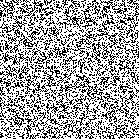

In [6]:
import com.squareup.gifencoder.GifEncoder
import com.squareup.gifencoder.ImageOptions
import java.io.ByteArrayOutputStream
import java.io.File
import java.util.concurrent.TimeUnit
import java.util.Base64

val outputStream = ByteArrayOutputStream()

// Configure GIF options
val options = ImageOptions().apply {
    setDelay(30, TimeUnit.MILLISECONDS) // 100ms per frame
}

// Encode GIF
val encoder = GifEncoder(outputStream, imageWidth, imageHeight, 0)
images.forEach { image ->
    val pixels = Array(imageHeight) { y ->
        IntArray(imageWidth) { x ->
            image.getRGB(x, y)
        }
    }
    //val pixels = image.getRGB(0,0,imageWidth, imageHeight, null, 0, imageWidth).asSequence().chunked(imageWidth).asSequence().map { it.toIntArray() }.toList().toTypedArray()
    encoder.addImage(pixels, options)
}

encoder.finishEncoding()
val gifBytes = outputStream.toByteArray()
val base64Gif = Base64.getEncoder().encodeToString(gifBytes)
Files.write(Paths.get("output.gif"), gifBytes)
// Display inline HTML image with embedded base64 GIF
DISPLAY(HTML("<img src='data:image/gif;base64,$base64Gif' width=${imageWidth * 8} style='image-rendering: pixelated;'/>"))